In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on the Grassmannian $\mathrm{Gr}(m, n)$

This notebook shows how define and evaluate kernels on the Grassmannian $\mathrm{Gr}(m, n)$ that consists of all $m$-dimensional subspaces of $\mathbb{R}^n$.

The Grassmannian is a homogeneous space space $\mathrm{Gr}(m, n) = \mathrm{O}(n) / (\mathrm{O}(m) \times \mathrm{O}(n-m))$, where $\mathrm{O}(k)$ is the orthogonal group of order $k$. Notable special cases are $\mathrm{Gr}(1, n)$, called *real projective spaces* $\mathrm{RP}^n$. These can be characterized as the hyperspheres $\mathbb{S}_{n-1}$ with all pairs of polar points $x$ and $-x$ identified.

The Grassmannian $\mathrm{Gr}(m, n)$ can be thought to consist of equivalence classes of elements of the Stiefel manifold $\mathrm{V}(m, n)$ from [Stiefel.ipynb](./Stiefel.ipynb). Recall that $\mathrm{V}(m, n)$ inself consists of $m$-tupes of orthonormal vectors in $\mathbb{R}^n$, or, alternatively, of $n \times m$ matrices with orthonormal columns. Then $\mathbf{X} \in \mathrm{Gr}(m, n)$ is of form $\mathbf{X} = \mathbf{U} \cdot \mathrm{O}(m)$ where $\mathbf{U}$ is an $n \times m$ matrix with orthonormal columns (i.e. $\mathbf{U} \in \mathrm{V}(m, n)$), and $\mathrm{O}(m)$ is the orhogonal group of matrices of size $m \times m$. That is, $\mathbf{X}$ is the equivalence class of all $\mathbf{U} \cdot \mathbf{O}$ with $\mathbf{O} \in \mathrm{O}(m)$.

We work with $\mathrm{Gr}(3, 7)$ here. There is no particular reason for this. Handling Grassmannians $\mathrm{Gr}(m, n)$ for other $n \geq 2$ and $m < n$ is the same.

**Note:** the "points" in the Grassmannian $\mathrm{Gr}(m, n)$ are represented by matrices of size $n \times m$ (`array`s of the suitable backend) with orthonormal columns (and real entries), just like the elements of `Stiefel`. However, for `Grassmannian`, this representation is not unique: two different matrices $\mathbf{X}_1$, $\mathbf{X}_2$ of said form can represent the same element of the Grassmannian if $\mathbf{X}_1 = \mathbf{X}_2 \mathbf{O}$ for some $m \times m$ orthogonal matrix $\mathbf{O}$.

We use the **numpy** backend here.

<!--TABLE OF CONTENTS-->
# Contents
- [**Basics**](#Basics)
  - [Defining a Space](#Defining-a-Space)
  - [Defining a Kernel](#Defining-a-Kernel)
  - [Evaluating Kernels on Random Inputs](#Evaluating-Kernels-on-Random-Inputs)
  - [Visualize Kernels](#Visualize-Kernels)
- [**Feature Maps and Sampling**](#Feature-Maps-and-Sampling)
  - [Defining a Feature Map](#Defining-a-Feature-Map)
  - [Efficient Sampling using Feature Maps](#Efficient-Sampling-using-Feature-Maps)
- [**The Simplest Special Case: Real Projective Space $\mathrm{RP}^3$**](#The-Simplest-Special-Case:-Real-Projective-Space-$\mathrm{RP}^3$)
  - [Visualize Kernels](#Visualize-Kernels)
  - [Visualize Samples](#Visualize-Samples)
- [**Citation**](#Citation)

# Basics

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np

# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Grassmannian
from geometric_kernels.kernels import MaternGeometricKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO (geometric_kernels): Numpy backend is enabled, as always. To enable other backends, don't forget `import geometric_kernels.*backend name*`.


## Defining a Space

First we create a GeometricKernels `space` that corresponds to the Grassmannian $\mathrm{Gr}(3, 7)$. Our implementation of `Grassmannian` computes the basis functions (that are needed to compute all the kernels) approximately, using Monte Carlo integration. Because of this, you need to provide a source of randomness when constructing the space, i.e. the random generator of the suitable backend, via the `key` keyword argument.

**Note**: the aforementioned basis functions are *zonal spherical functions*, these are (sums of outer products of certain groups of Laplace-Beltrami eigenfunctions). Perhaps a close enough examination of "Spherical functions on the Grassmann manifold and generalized Jacobi polynomials" by A. W. Davis or similar literature could yield exact algorithms for computing them - an interesting problem for future research.

In [3]:
m, n = 3, 7

key = np.random.RandomState(1234)

key, grassmannian = Grassmannian(m=m, n=n, key=key)

## Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `grassmannian` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel.
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on compact manifold like (which $\mathrm{Gr}(m, n)$ are examples of) can be found on these documentation pages: [one](https://gpflow.github.io/GeometricKernels/theory/compact.html), [two](https://gpflow.github.io/GeometricKernels/theory/addition_theorem.html).

In [4]:
kernel = MaternGeometricKernel(grassmannian)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [5]:
params = kernel.init_params()
print('params:', params)

params: {'lengthscale': array(1.), 'nu': array(inf)}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [6]:
params["lengthscale"] = np.array([0.5])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` (uniformly) random points in $\mathrm{Gr}(3, 7)$.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [7]:
key = np.random.RandomState(1234)

key, xs = grassmannian.random(key, 10)

print(xs)

[[[-4.26982203e-01 -3.28116114e-01  2.64951876e-01]
  [ 5.76503895e-01 -2.01403444e-01 -6.32401491e-01]
  [ 3.02576262e-01 -1.08182663e-01  3.62118198e-01]
  [ 5.94116132e-01 -1.35824997e-01  6.21081459e-01]
  [ 1.65842716e-01  3.68800332e-01  1.89132961e-02]
  [ 1.10579214e-01  1.06217614e-02 -6.35222804e-02]
  [-3.27340108e-02 -8.27948092e-01 -9.27593520e-02]]

 [[-1.40494035e-01  4.98706290e-01 -2.41511615e-01]
  [-2.31049718e-01  4.62799526e-02  2.37143193e-01]
  [ 1.36075745e-01  5.25290147e-01 -5.79422617e-01]
  [ 5.12610625e-01  1.06402938e-01  3.56372098e-01]
  [ 7.52277588e-01  1.30995557e-01  1.26726412e-01]
  [-1.07379438e-01 -2.04112693e-01  1.59820812e-01]
  [ 2.61035017e-01 -6.34883494e-01 -6.17334049e-01]]

 [[ 3.82464375e-01 -3.41012273e-01 -2.33627519e-01]
  [-4.87828415e-01 -5.46068888e-01 -2.65747641e-01]
  [ 1.61275400e-01  5.16384058e-01 -5.39979054e-02]
  [-1.41267940e-01 -1.73345164e-01 -4.96583274e-01]
  [ 1.71493245e-01 -2.00448386e-01  3.53632954e-01]
  [-6.77

Now we evaluate the two kernel matrices.

In [8]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

/Users/vabor112/anaconda3/envs/gkconda_updated_sh/lib/python3.10/site-packages/lab/numpy/generic.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  return a.astype(dtype, copy=False)


Finally, we visualize these matrices using `imshow`.

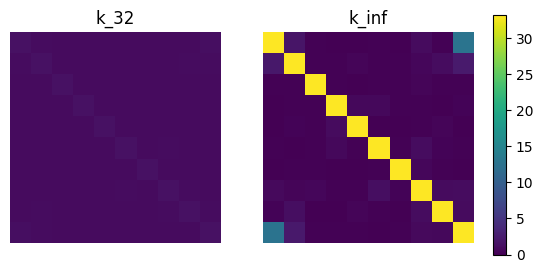

In [9]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Kernels

It is hard to visualize functions on $\mathrm{Gr}(m, n)$.
Functions are only easy to visualize on domains of dimension not higher than $2$.
However, we have $\dim \left(\mathrm{Gr}(m, n)\right) = m(n-m)$ which is greater than $2$ in almost all cases.

In [Stiefel.ipynb](./Stiefel.ipynb), we visualize functions on the Stiefel manifold $\mathrm{V}(m, n)$. Since all elements of the Grassmannian $\mathrm{Gr}(m, n)$ are equivalence classes of elements of $\mathrm{V}(m, n)$, we can use the same visualization trick as in [Stiefel.ipynb](./Stiefel.ipynb). It is important to be mindful of the fact that we might stumble upon elements of $\mathrm{V}(m, n)$ that represent the same element of $\mathrm{Gr}(m, n)$.

In [10]:
# define discretization
_NUM_ANGLES = 128

key, U = grassmannian.G.random(key, 2)  # stiefel.G returns an object representing SO(n)
U1 = U[0, :]
U2 = U[1, :]

# generate a grid on [0, 2 \pi)
angles = np.linspace(0, 2*np.pi, num=_NUM_ANGLES)
embedding = np.broadcast_to(np.eye(n), (_NUM_ANGLES, n, n)).copy()
embedding[:, 0, 0] = np.cos(angles)
embedding[:, 0, 1] = -np.sin(angles)
embedding[:, 1, 0] = np.sin(angles)
embedding[:, 1, 1] = np.cos(angles)

base_point = grassmannian.project_to_manifold(embedding[[0], :, :])

def conj_batch(U, emb):
    """ Compute U^T * emb[i, :] * U for all i.
    :param U:   [n, n] array
    :param emb: [N, n, n] array
    
    :return:    [N, n, n] array
    """
    return np.tensordot(np.tensordot(emb, U, axes=([2], [0])),
                        U.T, axes=([1], [1])
                       )

other_points1 = grassmannian.project_to_manifold(conj_batch(U1, embedding))
other_points2 = grassmannian.project_to_manifold(conj_batch(U2, embedding))

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points1` and $x \in $ `other_points2`, for $\nu$ either $3/2$ or $\infty$.

In [11]:
kernel_vals_32_1  = kernel.K(params_32,  base_point, other_points1)
kernel_vals_32_2  = kernel.K(params_32,  base_point, other_points2)
kernel_vals_inf_1 = kernel.K(params_inf, base_point, other_points1)
kernel_vals_inf_2 = kernel.K(params_inf, base_point, other_points2)

Finally, we are ready to plot the results.

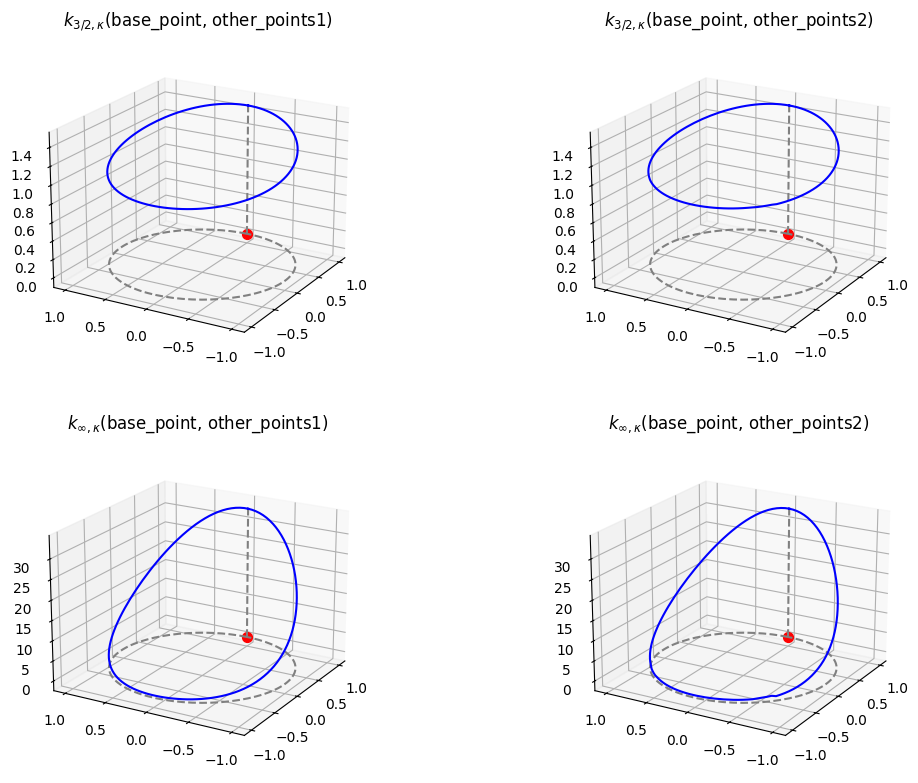

In [12]:
x_circle = np.cos(angles)
y_circle = np.sin(angles)
z_circle = np.zeros_like(angles) # z=0 for the circle

# Red ball position
red_ball_position = (x_circle[0], y_circle[0], z_circle[0])


def plot_kernel(ax, values, title):
    # Draw the unit circle
    ax.plot(x_circle, y_circle, z_circle, linestyle='dashed', color='gray')
    # Draw the red ball
    ax.scatter(*red_ball_position, color="r", s=50)
    # Draw the vertical dashed line
    ax.plot([1, 1], [0, 0], np.linspace(0, values[0, 0], 2), linestyle='dashed', color='gray')
    # Plot the new function evaluated only on the unit circle
    ax.plot(x_circle, y_circle, values[0, :], color='b')
    # Set the viewing angle for better visualization
    ax.view_init(elev=20., azim=180+30)
    ax.set_title(title)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12.8, 9.6), nrows=2, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

plot_kernel(ax1, kernel_vals_32_1,  r'$k_{3/2, \kappa}($base_point, other_points1$)$')
plot_kernel(ax2, kernel_vals_32_2,  r'$k_{3/2, \kappa}($base_point, other_points2$)$')
plot_kernel(ax3, kernel_vals_inf_1, r'$k_{\infty, \kappa}($base_point, other_points1$)$')
plot_kernel(ax4, kernel_vals_inf_2, r'$k_{\infty, \kappa}($base_point, other_points2$)$')


# Display the plot
plt.show()

# Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on the sphere, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

## Defining a Feature Map

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [13]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For the (hyper)sphere, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element is either `None` for determinstic feature maps, or contains the updated `key` for randomized feature maps which take `key` as a keyword argument.
For `default_feature_map` on a `Grassmannian` space, the first element is `key` since the feature map is *random*.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [14]:
# xs are random points from above
key, embedding = feature_map(xs, params_32, key=key)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (10, 7, 3)):
[[[-4.26982203e-01 -3.28116114e-01  2.64951876e-01]
  [ 5.76503895e-01 -2.01403444e-01 -6.32401491e-01]
  [ 3.02576262e-01 -1.08182663e-01  3.62118198e-01]
  [ 5.94116132e-01 -1.35824997e-01  6.21081459e-01]
  [ 1.65842716e-01  3.68800332e-01  1.89132961e-02]
  [ 1.10579214e-01  1.06217614e-02 -6.35222804e-02]
  [-3.27340108e-02 -8.27948092e-01 -9.27593520e-02]]

 [[-1.40494035e-01  4.98706290e-01 -2.41511615e-01]
  [-2.31049718e-01  4.62799526e-02  2.37143193e-01]
  [ 1.36075745e-01  5.25290147e-01 -5.79422617e-01]
  [ 5.12610625e-01  1.06402938e-01  3.56372098e-01]
  [ 7.52277588e-01  1.30995557e-01  1.26726412e-01]
  [-1.07379438e-01 -2.04112693e-01  1.59820812e-01]
  [ 2.61035017e-01 -6.34883494e-01 -6.17334049e-01]]

 [[ 3.82464375e-01 -3.41012273e-01 -2.33627519e-01]
  [-4.87828415e-01 -5.46068888e-01 -2.65747641e-01]
  [ 1.61275400e-01  5.16384058e-01 -5.39979054e-02]
  [-1.41267940e-01 -1.73345164e-01 -4.96583274e-01]
  [ 1.71493245e-01 -2.00448386e-01 

**Unfortunately:** $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$ does not hold, which is either caused by a bug or by the insufficiency of the default approximation order in this case. **TODO:** investigate this.

## Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.
Since we are going to compute each of the two samples at two different sets of inputs, `other_points1` and `other_points2`, we make sure the randomness if fixed by using the `make_deterministic` function.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
**However**, in our specific case, this keyword argument is not needed as it is automatically supplied by the `make_deterministic` wrapper.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [15]:
from geometric_kernels.sampling import sampler
from geometric_kernels.utils.utils import make_deterministic

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

sample_paths = make_deterministic(sampler(feature_map, s=2), key)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[ 0.28285953  1.82847649]
 [ 1.09420328  1.17530839]
 [-2.04436299 -0.14256369]
 [-1.78334209 -0.99451986]
 [ 0.18901749 -0.2304687 ]
 [-1.92558417  0.19431666]
 [-0.70339999  1.20022125]
 [-0.9205041  -0.27170088]
 [-1.1252724   1.18161002]
 [-0.74438277  0.63379232]]


### Visualizing Samples
Here we visualize samples as functions on the sphere.

In [ ]:
key, samples_other_points1 = sample_paths(other_points1, params_32)
key, samples_other_points2 = sample_paths(other_points2, params_32)

sample1_other_points1 = samples_other_points1[:, 0]
sample2_other_points1 = samples_other_points1[:, 1]
sample1_other_points2 = samples_other_points2[:, 0]
sample2_other_points2 = samples_other_points2[:, 1]

x_circle = np.cos(angles)
y_circle = np.sin(angles)
z_circle = np.zeros_like(angles) # z=0 for the circle

def plot_sample(ax, values, title):
    # Draw the unit circle
    ax.plot(x_circle, y_circle, z_circle, linestyle='dashed', color='gray')
    # Plot the new function evaluated only on the unit circle
    ax.plot(x_circle, y_circle, values, color='b')
    # Set the viewing angle for better visualization
    ax.view_init(elev=20., azim=180+30)
    ax.set_title(title)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12.8, 9.6), nrows=2, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

plot_sample(ax1, samples_other_points1[:, 0], r'Sample #1: $f(\cdot)$ for $\cdot$ in other_points1, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
plot_sample(ax2, samples_other_points2[:, 0], r'Sample #1: $f(\cdot)$ for $\cdot$ in other_points2, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
plot_sample(ax3, samples_other_points1[:, 1], r'Sample #2: $f(\cdot)$ for $\cdot$ in other_points1, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
plot_sample(ax4, samples_other_points2[:, 1], r'Sample #2: $f(\cdot)$ for $\cdot$ in other_points2, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')


# Display the plot
plt.show()

# The Simplest Special Case: Real Projective Space $\mathrm{RP}^3$

Here we visualize the kernel and samples in the simplest special case, for the real projective space $\mathrm{RP}^3$ that can be thought of as the standard two-dimensional sphere for which every pair of opposite points, i.e. $x$ and $-x$, is identified. In this case, we can visualize functions on $\mathrm{RP}^3$ as functions on the $2$-dimensional sphere.

In [3]:
key = np.random.RandomState(1234)

projective = Grassmannian(m=1, n=3, key=key)

kernel_projective = MaternGeometricKernel(projective)

params_32  = {"lengthscale": np.array([0.125]), "nu": np.array([3/2])}
params_inf = {"lengthscale": np.array([0.125]), "nu": np.array([np.inf])}

ValueError: Only n >= 3 is supported. For n = 2, use Circle.

## Visualize Kernels
We use the same code as in [Hypersphere.ipynb](./Hypersphere.ipynb).

In [ ]:
base_point = np.array([[0.0, 0.0, 1.0]])

# define latitude and longitude discretization
_NUM_LATS = 128
_NUM_LONGS = 128

# generate a grid on the sphere
lats, longs =  np.mgrid[0:2*np.pi:_NUM_LATS*1j, 0:np.pi:_NUM_LONGS*1j]

other_points_xs = np.sin(longs) * np.cos(lats)
other_points_ys = np.sin(longs) * np.sin(lats)
other_points_zs = np.cos(longs)

other_points = np.c_[np.ravel(other_points_xs),
                     np.ravel(other_points_ys),
                     np.ravel(other_points_zs)]

# The elements of `projective` are matrices 3x1 rather than 3-dim vectors.
base_point = base_point[..., np.newaxis]
other_points = other_points[..., np.newaxis]


kernel_vals_32  = kernel_projective.K(params_32,  base_point, other_points)
kernel_vals_inf = kernel_projective.K(params_inf, base_point, other_points)

fig, (ax1, ax2) = plt.subplots(figsize=(12.8, 4.8), nrows=1, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

cmap = plt.get_cmap('viridis')

surf1 = ax1.plot_surface(other_points_xs, other_points_ys, other_points_zs,
                         facecolors=cmap(kernel_vals_32[0, :].reshape(_NUM_LATS, _NUM_LONGS)),  cstride=1, rstride=1)
surf2 = ax2.plot_surface(other_points_xs, other_points_ys, other_points_zs,
                         facecolors=cmap(kernel_vals_inf[0, :].reshape(_NUM_LATS, _NUM_LONGS)), cstride=1, rstride=1)

# Remove axis
ax1._axis3don = False
ax2._axis3don = False

# Set aspect ratio
ax1.set_box_aspect((np.ptp(other_points_xs), np.ptp(other_points_ys),
                    np.ptp(other_points_zs)), zoom=1.5)
ax2.set_box_aspect((np.ptp(other_points_xs), np.ptp(other_points_ys),
                    np.ptp(other_points_zs)), zoom=1.5)

# plot the base point
ax1.scatter(base_point[0, 0], base_point[0, 1], base_point[0, 2], s=10, c='r', marker='D')
ax2.scatter(base_point[0, 0], base_point[0, 1], base_point[0, 2], s=10, c='r', marker='D')

# find common range of values
minmin_vis = np.min([np.min(kernel_vals_32), np.min(kernel_vals_inf)])
maxmax_vis = np.max([np.max(kernel_vals_32), np.max(kernel_vals_inf)])

ax1.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$')
ax2.set_title('$k_{\infty, \kappa}($base_point, other_points$)$')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Samples
We use the same code as in [Hypersphere.ipynb](./Hypersphere.ipynb).

In [ ]:
from geometric_kernels.kernels import default_feature_map
from geometric_kernels.sampling import sampler

feature_map = default_feature_map(kernel=kernel_projective)
sample_paths = sampler(feature_map, s=2)

key = np.random.RandomState(seed=1234)
key, samples = sample_paths(other_points, params_32, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

fig, (ax1, ax2) = plt.subplots(figsize=(12.8, 4.8), nrows=1, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

cmap = plt.get_cmap('viridis')

surf1 = ax1.plot_surface(other_points_xs, other_points_ys, other_points_zs,
                         facecolors=cmap(sample1.reshape(_NUM_LATS, _NUM_LONGS)),  cstride=1, rstride=1)
surf2 = ax2.plot_surface(other_points_xs, other_points_ys, other_points_zs,
                         facecolors=cmap(sample2.reshape(_NUM_LATS, _NUM_LONGS)), cstride=1, rstride=1)

# Remove axis
ax1._axis3don = False
ax2._axis3don = False

# Set aspect ratio
ax1.set_box_aspect((np.ptp(other_points_xs), np.ptp(other_points_ys),
                    np.ptp(other_points_zs)), zoom=1.5)
ax2.set_box_aspect((np.ptp(other_points_xs), np.ptp(other_points_ys),
                    np.ptp(other_points_zs)), zoom=1.5)

# find common range of values
minmin_vis = np.min([np.min(sample1), np.min(sample2)])
maxmax_vis = np.max([np.max(sample1), np.max(sample2)])

ax1.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in other_points, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
ax2.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in other_points, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)
plt.show()

# Citation

If you are using Lie groups and GeometricKernels, please consider citing

```
@article{azangulov2022,
    title={Stationary kernels and Gaussian processes on Lie groups and their homogeneous spaces I: the compact case},
    author={Azangulov, Iskander and Smolensky, Andrei and Terenin, Alexander and Borovitskiy, Viacheslav},
    journal={arXiv preprint arXiv:2208.14960},
    year={2022}
}
```